This file is to implement a sox dependency reduction task for bass (with biquad) following https://github.com/pytorch/audio/issues/260. 
Its method is based on the implementation of task for treble with biquad https://github.com/pytorch/audio/blob/master/torchaudio/functional.py#L1025.
Here we want to compare and test the result from sox and our bass_biquad function.


In [4]:
import torch 
import torchaudio
from torch import Tensor
import torchaudio.functional_update as F
import common_utils
import matplotlib.pyplot as plt
import IPython.display as ipd

# try another option to see the test https://gist.github.com/endolith/5455375
from biquad_cookbook import shelf

Let us write the bass_biquad function. The form of biqard transfer function can follow below link https://en.wikipedia.org/wiki/Digital_biquad_filter.
The coefficients of transfer function is from the reference
https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF.
The default value of central_freq is 100 Hz, which is from the reference.
http://sox.sourceforge.net/sox.html.

In [5]:
def bass_biquad(
        waveform: Tensor,
        sample_rate: int,
        gain: float,
        central_freq: float = 100,
        Q: float = 0.707
) -> Tensor:
    r"""Design a bass tone-control effect.  Similar to SoX implementation.
    Args:
        waveform (Tensor): audio waveform of dimension of `(..., time)`
        sample_rate (int): sampling rate of the waveform, e.g. 44100 (Hz)
        gain (float): desired gain at the boost (or attenuation) in dB.
        central_freq (float, optional): central frequency (in Hz). (Default: ``100``)
        Q (float, optional): https://en.wikipedia.org/wiki/Q_factor (Default: ``0.707``).
    Returns:
        Tensor: Waveform of dimension of `(..., time)`
    References:
        http://sox.sourceforge.net/sox.html
        https://www.w3.org/2011/audio/audio-eq-cookbook.html#APF
    """
    w0 = 2 * math.pi * central_freq / sample_rate
    alpha = math.sin(w0) / 2 / Q
    A = math.exp(gain / 40 * math.log(10))

    temp1 = 2 * math.sqrt(A) * alpha
    temp2 = (A - 1) * math.cos(w0)
    temp3 = (A + 1) * math.cos(w0)

    b0 = A * ((A + 1) - temp2 + temp1)
    b1 = 2 * A * ((A - 1) - temp3)
    b2 = A * ((A + 1) - temp2 - temp1)
    a0 = (A + 1) + temp2 + temp1
    a1 = -2 * ((A - 1) + temp3)
    a2 = (A + 1) + temp2 - temp1

    return biquad(waveform, b0, b1, b2, a0, a1, a2)

Then we conduct the test to compare the difference between sox output (sox_output_waveform) and our function result (output_waveform).

In [6]:
central_freq = 1000
q = 0.707
gain = 40

filename = 'steam-train-whistle-daniel_simon.mp3'
#filename = 'sinewave.wav'
noise_filepath = common_utils.get_asset_path(filename)
E = torchaudio.sox_effects.SoxEffectsChain()
E.set_input_file(noise_filepath)
E.append_effect_to_chain("bass", [gain, central_freq, str(q) + 'q'])
sox_output_waveform, sr = E.sox_build_flow_effects()

waveform, sample_rate = torchaudio.load(noise_filepath, normalization=True)
output_waveform = F.bass_biquad(waveform, sample_rate, gain, central_freq, q)

#self.assertEqual(output_waveform, sox_output_waveform, atol=1e-4, rtol=1e-5)

    

Let us play the audio to see how it sounds ike.

In [7]:
ipd.Audio(noise_filepath)

Firstly, we set a value of absolute tolorence (atol) and see how many elements are larger than atol

In [8]:
atol = 1e-4
diff = abs(output_waveform - sox_output_waveform)
print((diff > atol).sum())

tensor(33557)


We can look at the log of the initial spectrogram on a log scale.

Shape of spectrogram: torch.Size([2, 201, 1394])


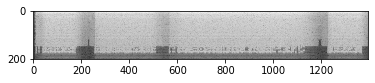

In [9]:
specgram = torchaudio.transforms.Spectrogram()(waveform)

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy(), cmap='gray')

Then we look at the log of the spectrogram from bass_biquad function and sox on a log scale.

Shape of spectrogram: torch.Size([2, 201, 1394])


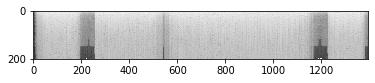

In [10]:
specgram_audio = torchaudio.transforms.Spectrogram()(output_waveform)

print("Shape of spectrogram: {}".format(specgram_audio.size()))

plt.figure()
p = plt.imshow(specgram_audio.log2()[0,:,:].detach().numpy(), cmap='gray')

Shape of spectrogram: torch.Size([2, 201, 1394])


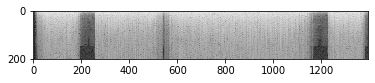

In [11]:
specgram_sox = torchaudio.transforms.Spectrogram()(sox_output_waveform)

print("Shape of spectrogram: {}".format(specgram_sox.size()))

plt.figure()
p = plt.imshow(specgram_sox.log2()[0,:,:].detach().numpy(), cmap='gray')

We plot the difference between two specgram signals on a log scale.

Shape of spectrogram: torch.Size([2, 201, 1394])


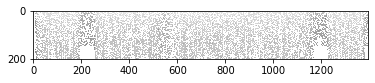

In [12]:
specgram_diff = specgram_audio - specgram_sox
print("Shape of spectrogram: {}".format(specgram_diff.size()))

plt.figure()
p = plt.imshow(specgram_diff.log2()[0,:,:].detach().numpy(), cmap='gray')

Let us look at a time slice of specgram_diff with the maximum value.

In [13]:
print(specgram_diff.shape)

torch.Size([2, 201, 1394])


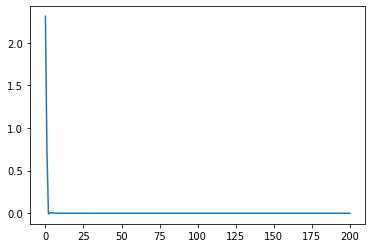

In [14]:
values, indices = specgram_diff[0,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[0]].numpy())

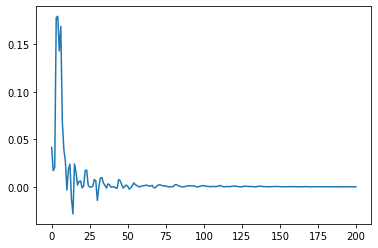

In [15]:
values, indices = specgram_diff[0,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[100]].numpy())

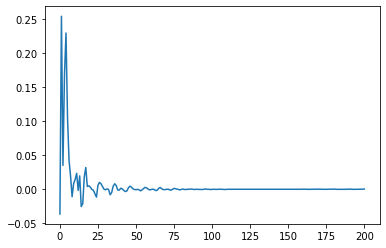

In [16]:
values, indices = specgram_diff[0,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[200]].numpy())

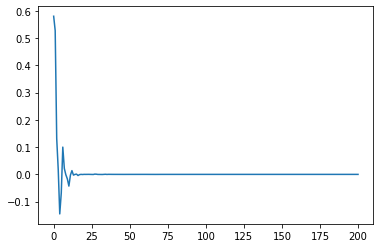

In [17]:
values, indices = specgram_diff[1,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[0]].numpy())

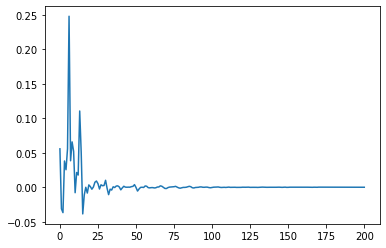

In [18]:
values, indices = specgram_diff[1,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[100]].numpy())

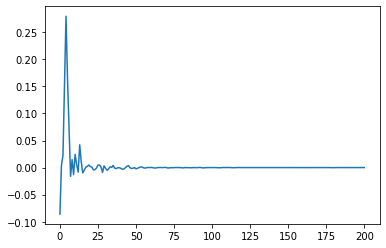

In [19]:
values, indices = specgram_diff[1,:,:].topk(1)

plt.figure()
p = plt.plot(specgram_diff[0,:,indices[200]].numpy())